In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import convert_temperature as conv_temp

import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Controllers import ControllerBase
from Controllers import PIDController
from Controllers import LQRController_disc
from Controllers import LQRController_cont
from Classes import LEDparams, Model

In [2]:
class Simulation:
    def __init__(self, model:Model, controller:ControllerBase, dt:float, time_span:float) -> None:
        self.model = model
        self.controller = controller

        assert dt > 0, "dt must be greater than 0"
        assert time_span > 0, "time_span must be greater than 0"
        assert time_span >= dt, "time_span must be greater than or equal to dt"

        self.dt = dt
        self.time_span = time_span
        self.time_steps = int(self.time_span / self.dt)

        self.data = {
            "time":     [],
            "SoC":      [],
            "T_HP_c":   [],
            "T_HP_h":   [],
            "I_HP":     [],
            "x_FAN":    [],
            "T_cell":   [],
            "I_BT":     [],
            "U_BT":     [],
            "U_oc":     [],
            "U_HP":     [],
            "COP":      [],
        }

    def run(self) -> pd.DataFrame:
        x = self.model.get_initial_state

        for t in range(self.time_steps):
            current_time = t * self.dt

            y = self.model.get_output()

            u = self.controller.get_control_input(x, y)

            # Advance system states
            x = self.model.discretized_update(u, self.dt)

            # Get internal values
            values = self.model.get_values(x, u)

            self.data["time"].append(current_time)
            self.data["SoC"].append(x[0])
            self.data["T_HP_c"].append(x[1])
            self.data["T_HP_h"].append(x[2])
            self.data["I_HP"].append(u[0])
            self.data["x_FAN"].append(u[1])
            self.data["T_cell"].append(y[0])
            self.data["I_BT"].append(values[4])
            self.data["U_BT"].append(values[0])
            self.data["U_oc"].append(values[1])
            self.data["U_HP"].append(values[2])
            self.data["COP"].append(values[3])

        return pd.DataFrame(self.data)

In [ ]:
LEDpar = LEDparams()
LEDpar.program_reader()

# Initial conditions
T_amb0 = conv_temp(25.0, 'C', 'K') # K
x0 = np.array([0.9, T_amb0, T_amb0])

model = Model(LEDpar, x0, T_amb0=T_amb0)

dt_sim = 1 # s
time_span = 60 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

dt_disc = 0.0
setpoint = conv_temp(37.0, 'C', 'K') # K

# PID
# kp, ki, kd = -2.5, -4.0, 0.0
# output_limits = (-model.I_HP_max, model.I_HP_max) # A
# controller = PIDController(kp, ki, kd, setpoint, dt_disc, output_limits)

# LQR
A, B, h, C, D, l = model.get_linearization()
Q = np.array([[0, 0, 0],
              [0, 1, 0],
              [0, 0, 0]])
R = np.array([[1/3, 0],
              [0, 1]])
controller = LQRController_cont(model, setpoint, A, B, Q, R)
K = controller.K
# Save matrices as csv
directory = 'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\Data\\State Space\\'
np.savetxt(directory + 'A.csv', A, delimiter=',')
np.savetxt(directory + 'B.csv', B, delimiter=',')
np.savetxt(directory + 'h.csv', h, delimiter=',')
np.savetxt(directory + 'C.csv', C, delimiter=',')
np.savetxt(directory + 'D.csv', D, delimiter=',')
np.savetxt(directory + 'l.csv', l, delimiter=',')

sim = Simulation(model, controller, dt_sim, time_span)

# Run the simulation
results = sim.run()

# Conversion
results[["T_cell", "T_HP_c", "T_HP_h"]] = conv_temp(results[["T_cell", "T_HP_c", "T_HP_h"]].to_numpy(), 'K', 'C')

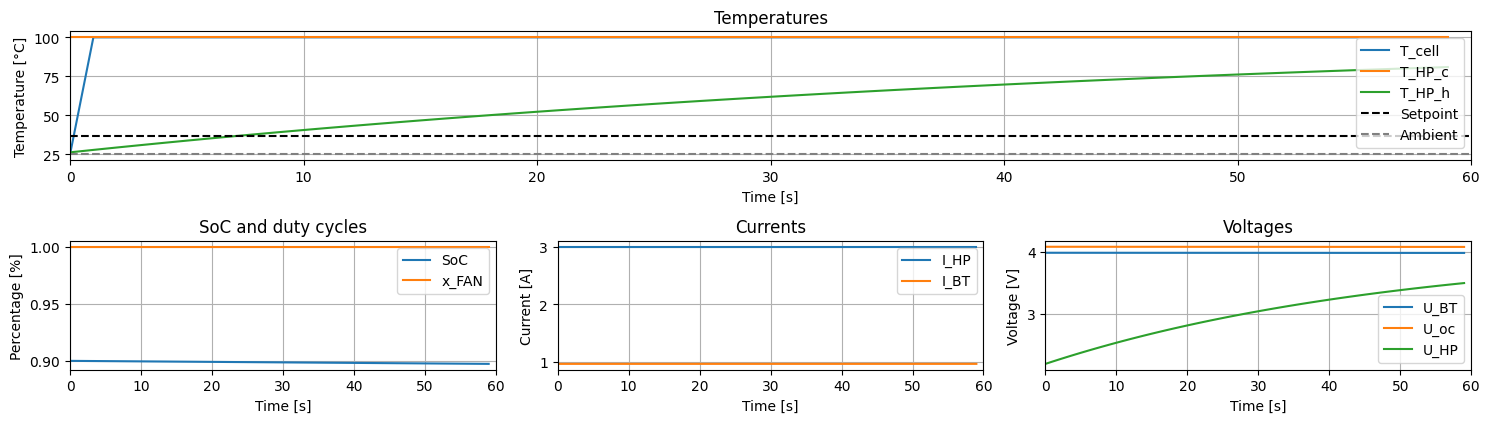

In [4]:
xlimits = (0, time_span)

fig = plt.figure(figsize=(15, 6))

gs = fig.add_gridspec(3, 3)

# Temperatures
ax0 = fig.add_subplot(gs[0, :])  # Span the first row across both columns
ax = results.plot(
    x="time", 
    y=["T_cell", "T_HP_c", "T_HP_h"], 
    xlabel="Time [s]", 
    ylabel="Temperature [°C]", 
    title="Temperatures",
    ax=ax0
)
ax.axhline(
    y=conv_temp(setpoint, 'K', 'C'), 
    color='black', 
    linestyle='--', 
    label='Setpoint'
)
ax.axhline(
    y=conv_temp(T_amb0, 'K', 'C'), 
    color='gray', 
    linestyle='--', 
    label='Ambient'
)
ax.legend()
ax.grid()
ax.set_xlim(xlimits)

# Soc and duty cycles
ax1 = fig.add_subplot(gs[1, 0])
ax = results.plot(
    x="time", 
    y=["SoC", "x_FAN"], 
    xlabel="Time [s]", 
    ylabel="Percentage [%]", 
    title="SoC and duty cycles",
    ax=ax1
)
ax.legend()
ax.grid()
ax.set_xlim(xlimits)

# Currents
ax2 = fig.add_subplot(gs[1, 1])
ax = results.plot(
    x="time", 
    y=["I_HP", "I_BT"], 
    xlabel="Time [s]", 
    ylabel="Current [A]", 
    title="Currents",
    ax=ax2
)
ax.legend()
ax.grid()
ax.set_xlim(xlimits)

# Voltages
ax3 = fig.add_subplot(gs[1, 2])
ax = results.plot(
    x="time", 
    y=["U_BT", "U_oc", "U_HP"], 
    xlabel="Time [s]", 
    ylabel="Voltage [V]", 
    title="Voltages",
    ax=ax3
)
ax.legend()
ax.grid()
ax.set_xlim(xlimits)

# Adjust layout
plt.tight_layout()
plt.show()


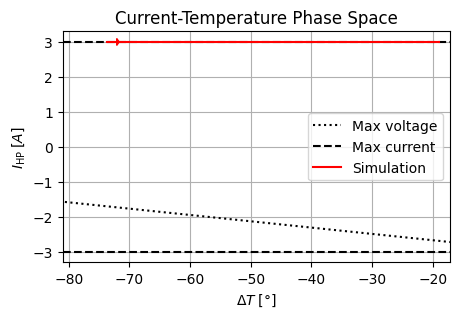

In [5]:
x_sim = results["T_HP_h"].to_numpy() - results["T_HP_c"].to_numpy()
y_sim = results["I_HP"].to_numpy()
COP_sim = results["COP"].to_numpy()

x = results[["SoC", "T_HP_c", "T_HP_h"]].to_numpy().T
u = results[["I_HP", "x_FAN"]].to_numpy().T

def get_constraints(delta_T:np.ndarray) -> np.ndarray:
    y_vec_min = (-model.U_BT_num(x, u) - model.S_M * (delta_T)) / model.R_M
    y_vec_max = (model.U_BT_num(x, u) - model.S_M * (delta_T)) / model.R_M
    return y_vec_min, y_vec_max

x_vec = np.linspace(-100, 100, len(x_sim))
y_vec_min, y_vec_max = get_constraints(x_vec)

## Arrows
# Steps and thresholds to sparse the arrows
arrow_step = 30
# threshold_dx = 1.0
# threshold_dy = 0.003

# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
# # Remove noise
# window_size = 20
# smoothed_x_sim = moving_average(x_sim, window_size)
# smoothed_y_sim = moving_average(y_sim, window_size)

# dx = np.diff(smoothed_x_sim)
# dy = np.diff(smoothed_y_sim)

# # Mask to filter and get only transients
# arrow_mask = (np.abs(dx) > threshold_dx) | (np.abs(dy) > threshold_dy)
# arrow_mask = np.concatenate((np.zeros(window_size), arrow_mask))
# arrow_mask = np.cumsum(arrow_mask[::-1]) > 0
# arrow_mask = arrow_mask[::-1]

# arrow_x_vec = x_sim[arrow_mask]
# arrow_y_vec = y_sim[arrow_mask]

# arrow_dx_vec = dx[arrow_mask[window_size:]]
# arrow_dy_vec = dy[arrow_mask[window_size:]]

# arrow_x_vec = arrow_x_vec[::arrow_step]
# arrow_y_vec = arrow_y_vec[::arrow_step]
# arrow_dx_vec = arrow_dx_vec[::arrow_step]
# arrow_dy_vec = arrow_dy_vec[::arrow_step]

# Plot
plt.figure(figsize=(5, 3))
plt.plot(x_vec, y_vec_min, color='k', linestyle=':', label='Max voltage')
plt.plot(x_vec, y_vec_max, color='k', linestyle=':')
plt.axhline(y=model.I_HP_max, color='black', linestyle='--', label='Max current')
plt.axhline(y=-model.I_HP_max, color='black', linestyle='--')
plt.plot(x_sim, y_sim, color='r', label='Simulation')
# for i in range(len(arrow_x_vec)):
#     plt.arrow(
#         arrow_x_vec[i], arrow_y_vec[i],
#         arrow_dx_vec[i], arrow_dy_vec[i], 
#         head_width=0.2, head_length=0.4, fc='red', ec='red'
#     )
for i in range(0, len(x_sim) - arrow_step, arrow_step):
    plt.arrow(
        x_sim[i], y_sim[i], 
        x_sim[i + 1] - x_sim[i], y_sim[i + 1] - y_sim[i], 
        head_width=0.2, head_length=0.4, fc='red', ec='red'
    )
plt.xlabel(r'$\Delta T \; [°]$')
plt.ylabel(r'$I_\mathrm{HP} \; [A]$')
plt.title('Current-Temperature Phase Space')

plt.xlim(x_sim.min() - abs(x_sim.min()) * 0.1, x_sim.max() + abs(x_sim.max()) * 0.1)
plt.ylim(-model.I_HP_max * 1.1, model.I_HP_max * 1.1)
plt.grid()
plt.legend()
plt.show()

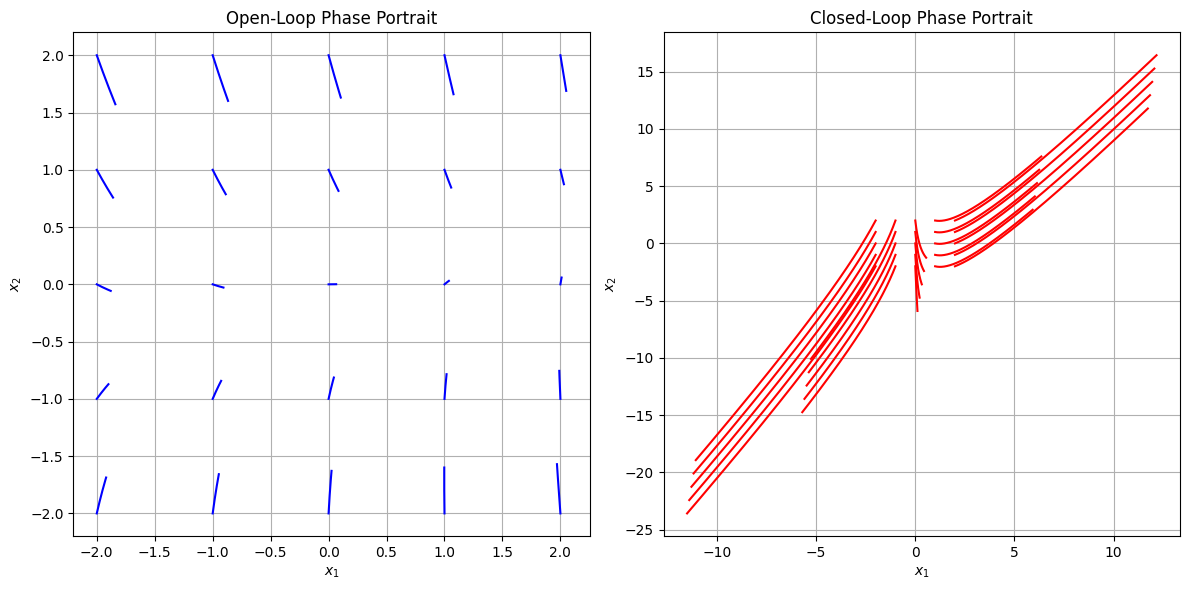

In [6]:
from scipy.integrate import odeint

K = controller.K

# Initial condition for x[0]
x0_fixed = 0.85

# Define the open-loop system dynamics
def open_loop(x, t):
    return A @ x

# Define the closed-loop system dynamics
def closed_loop(x, t):
    u = -K @ x  # Control input from LQR
    return (A - B @ K) @ x

# Time vector for simulation
time = np.linspace(0, 10, 500)

# Initial conditions for x[1] and x[2]
x1_vals = np.linspace(-2, 2, 5)
x2_vals = np.linspace(-2, 2, 5)

# Create a meshgrid of initial conditions
x1_grid, x2_grid = np.meshgrid(x1_vals, x2_vals)

# Plot phase portrait for open-loop system
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for x1 in x1_vals:
    for x2 in x2_vals:
        x_init = [x0_fixed, x1, x2]
        x_trajectory = odeint(open_loop, x_init, time)
        plt.plot(x_trajectory[:, 1], x_trajectory[:, 2], 'b')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Open-Loop Phase Portrait')
plt.grid()

# Plot phase portrait for closed-loop system
plt.subplot(1, 2, 2)
for x1 in x1_vals:
    for x2 in x2_vals:
        x_init = [x0_fixed, x1, x2]
        x_trajectory = odeint(closed_loop, x_init, time)
        plt.plot(x_trajectory[:, 1], x_trajectory[:, 2], 'r')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Closed-Loop Phase Portrait')
plt.grid()

plt.tight_layout()
plt.show()


C:\Users\giaco\AppData\Local\Temp\ipykernel_10620\1705330687.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[2]
C:\Users\giaco\AppData\Local\Temp\ipykernel_10620\1705330687.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[1]


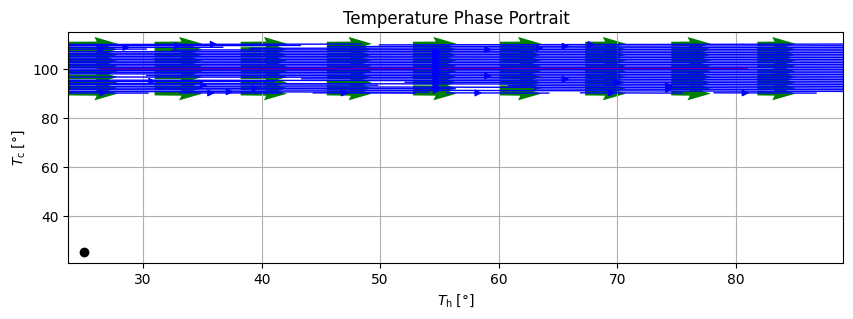

In [7]:
x_FAN = 1.0
x_SoC = 0.85
I_HP = 1.2

lenght_data = 10

# Define the system of equations dTh/dt = f3(Th, Tc) and dTc/dt = f2(Th, Tc)
def f3(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
    tmp = np.zeros_like(Th)

    for i in range(lenght_data):
        tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[2]

    return tmp

def f2(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
    tmp = np.zeros_like(Th)

    for i in range(lenght_data):
        tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[1]

    return tmp

Th_sim = results["T_HP_h"].to_numpy()
Tc_sim = results["T_HP_c"].to_numpy()

# Create a grid of points in the (x, y) plane
x = np.linspace(Th_sim.min()-abs(Th_sim.min())*0.1, Th_sim.max()+abs(Th_sim.max())*0.1, lenght_data)
y = np.linspace(Tc_sim.min()-abs(Tc_sim.min())*0.1, Tc_sim.max()+abs(Tc_sim.max())*0.1, lenght_data)
X, Y = np.meshgrid(x, y)

# Compute the vector field at each grid point
u = f3(x, y)
v = f2(x, y)
U, V = np.meshgrid(u, v)

# Plot the streamlines using the quiver function
plt.figure(figsize=(10, 3))
plt.quiver(X, Y, U, V, color='g')  # Arrows indicating the direction field
plt.plot(Th_sim, Tc_sim, color='r')
plt.plot(conv_temp(T_amb0, 'K', 'C'), conv_temp(T_amb0, 'K', 'C'), 'o', color='black', label='Ambient')
plt.xlabel(r"$T_\mathrm{h} \; [°]$")
plt.ylabel(r"$T_\mathrm{c} \; [°]$")
plt.title('Temperature Phase Portrait')

# Additionally, plot using streamplot for smoother visualization
plt.streamplot(X, Y, U, V, color='b', linewidth=1)

plt.grid()
plt.show()